## Data prep

### Trim video based on timestamp CSV

In [1]:
import pandas as pd

def time_to_seconds(t):
    parts = t.split(':')
    parts = [float(p) for p in parts]
    if len(parts) == 3:  # HH:MM:SS
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    elif len(parts) == 2:  # MM:SS
        return parts[0] * 60 + parts[1]
    else:
        return parts[0]

def generate_ffmpeg_commands(df, label):
    commands = []
    for i, row in df.iterrows():
        start_sec = time_to_seconds(row["start_time"])
        end_sec = time_to_seconds(row["end_time"])
        duration = end_sec - start_sec
        outname = f"{label}_clip_{i:03d}.mp4"
        cmd = f'ffmpeg -i cycling1080p.mov -ss {start_sec:.2f} -t {duration:.2f} -c:v libx264 -an clips/{outname}'
        commands.append(cmd)
    return commands

# Load CSVs
signal_df = pd.read_csv("./signal.csv")
nosignal_df = pd.read_csv("./nosignal.csv")

# Generate FFmpeg commands
signal_cmds = generate_ffmpeg_commands(signal_df, "signal")
nosignal_cmds = generate_ffmpeg_commands(nosignal_df, "nosignal")

# Save all commands to a bash script
with open("extract_clips.sh", "w") as f:
    f.write("\n".join(signal_cmds + nosignal_cmds))


### Determine cropping coordinates

In [2]:
import cv2
import os

# Load the first video from ./clips (just pick one sample clip)
clip_path = "./clips"
first_clip = sorted(os.listdir(clip_path))[0]
video_path = os.path.join(clip_path, first_clip)

# Read the first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

# Select ROI interactively
roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w, h = roi
print(f"Selected crop: x={x}, y={y}, width={w}, height={h}")


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Selected crop: x=856, y=226, width=1052, height=848


### Run bash script to crop video

In [ ]:
import os

# Crop region
x, y, w, h = 856, 226, 1052, 848

# Directories
input_dir = "./clips"
output_dir = "./clips_cropped"
os.makedirs(output_dir, exist_ok=True)

# Generate crop commands
for fname in sorted(os.listdir(input_dir)):
    if fname.endswith(".mp4"):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)
        cmd = f'ffmpeg -i "{in_path}" -filter:v "crop={w}:{h}:{x}:{y}" -c:a copy "{out_path}"'
        os.system(cmd)


### ByteTrack

In [160]:
from ultralytics import YOLO
import cv2
import json

# Paths
num = "100"
video_path = "./clips_cropped/signal_clip_"+num+".mp4"
tracks_path = "./pose_keypoints/signal_clip_"+num+"_tracks.json"
output_path = "./clips_cropped/signal_clip_"+num+"_tracks_overlay.mp4"

# Load YOLOv8 with tracking (must be detection model, not pose)
model = YOLO("yolov8s.pt")  # NOT yolov8n-pose.pt

video_path = "./clips_cropped/signal_clip_"+num+".mp4"
cap = cv2.VideoCapture(video_path)

frame_id = 0
detections = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Track=True enables ByteTrack
    results = model.track(frame, persist=True, classes=[0], tracker="bytetrack.yaml")

    # Only keep 'person' detections (class 0)
    for box, track_id in zip(results[0].boxes.xyxy, results[0].boxes.id):
        if track_id is None:
            continue
        x1, y1, x2, y2 = box.tolist()
        detections.append({
            "frame": frame_id,
            "id": int(track_id),
            "bbox": [x1, y1, x2, y2]
        })

    frame_id += 1

cap.release()

# Save detections for pose tracking
with open(tracks_path, "w") as f:
    json.dump(detections, f)

# --- --- ---
# --- --- ---
# --- --- ---

# Load tracking data
with open(tracks_path, "r") as f:
    all_detections = json.load(f)

# Index by frame
track_by_frame = {}
for det in all_detections:
    frame = det["frame"]
    if frame not in track_by_frame:
        track_by_frame[frame] = []
    track_by_frame[frame].append(det)

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    detections = track_by_frame.get(frame_id, [])

    for det in detections:
        x1, y1, x2, y2 = map(int, det["bbox"])
        track_id = det["id"]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    writer.write(frame)
    frame_id += 1

cap.release()
writer.release()


100%|██████████| 21.5M/21.5M [00:01<00:00, 16.9MB/s]



0: 544x640 4 persons, 240.8ms
Speed: 4.7ms preprocess, 240.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 184.4ms
Speed: 1.6ms preprocess, 184.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 225.5ms
Speed: 1.7ms preprocess, 225.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 200.6ms
Speed: 1.7ms preprocess, 200.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 202.5ms
Speed: 2.4ms preprocess, 202.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 215.1ms
Speed: 2.5ms preprocess, 215.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 176.7ms
Speed: 1.6ms preprocess, 176.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 184.4ms
Speed: 1.6ms preprocess, 184.4ms inference, 1.0ms postprocess per 

### Tracking-guided pose estimation

In [161]:
import cv2
import json
import os
from ultralytics import YOLO

# Paths
video_path = "./clips_cropped/signal_clip_"+num+".mp4"
tracks_path = "./pose_keypoints/signal_clip_"+num+"_tracks.json"
output_path = "./pose_keypoints/signal_clip_"+num+"_pose_id1.json"

# Constants
target_id = 1
pose_model = YOLO("yolov8s-pose.pt")

# Load tracking data
with open(tracks_path, "r") as f:
    all_detections = json.load(f)

# Index by frame
track_by_frame = {}
for det in all_detections:
    if det["id"] == target_id:
        frame = det["frame"]
        track_by_frame[frame] = det["bbox"]  # only keep 1 box per frame for this ID

# Open video
cap = cv2.VideoCapture(video_path)
frame_id = 0
pose_results = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_id in track_by_frame:
        H, W = frame.shape[:2]
        x1, y1, x2, y2 = track_by_frame[frame_id]
        w = x2 - x1
        h = y2 - y1

        # Expand amount in each direction
        threshold = 0.35 # percent expansion of box
        margin_x = threshold * w
        margin_y = threshold * h

        x1_exp = max(0, int(x1 - margin_x))
        y1_exp = max(0, int(y1 - margin_y))
        x2_exp = min(W, int(x2 + margin_x))
        y2_exp = min(H, int(y2 + margin_y))

        crop = frame[y1_exp:y2_exp, x1_exp:x2_exp]

        # Pose estimation on cropped person
        results = pose_model(crop)
        if results and results[0].keypoints.xy is not None:
            keypoints = results[0].keypoints.xy[0].cpu().tolist()
            # Convert to full-frame coords
            keypoints_full = [[x + x1_exp, y + y1_exp] for x, y in keypoints]
        else:
            keypoints_full = []
    else:
        keypoints_full = []

    pose_results.append({
        "frame": frame_id,
        "keypoints": keypoints_full
    })
    frame_id += 1

cap.release()

# Save to JSON
with open(output_path, "w") as f:
    json.dump(pose_results, f)



0: 640x320 1 person, 198.8ms
Speed: 1.3ms preprocess, 198.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 person, 160.6ms
Speed: 0.9ms preprocess, 160.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 person, 212.2ms
Speed: 1.3ms preprocess, 212.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 person, 146.5ms
Speed: 10.7ms preprocess, 146.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 person, 97.1ms
Speed: 1.2ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 person, 111.4ms
Speed: 1.2ms preprocess, 111.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 person, 82.9ms
Speed: 1.0ms preprocess, 82.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 person, 86.1ms
Speed: 1.0ms preprocess, 86.1ms inference, 0.8ms postprocess per image at shap

### Overlay the estimate

In [162]:
import cv2
import json

# Paths
video_path = "./clips_cropped/signal_clip_"+num+".mp4"
keypoint_path = "./pose_keypoints/signal_clip_"+num+"_pose_id1.json"
output_path = "./clips_cropped/signal_clip_"+num+"_pose_id1_overlay.mp4"

# Load pose data
with open(keypoint_path, "r") as f:
    pose_data = json.load(f)

# COCO skeleton edges
skeleton = [
    (5, 7), (7, 9),  # Left arm
    (6, 8), (8, 10), # Right arm
    (5, 6), (5, 11), (6, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
    (11, 12)
]

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret or frame_id >= len(pose_data):
        break

    keypoints = pose_data[frame_id]["keypoints"]

    if keypoints and len(keypoints) == 17:
        # Draw joints
        for x, y in keypoints:
            cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 0), -1)

        # Draw skeleton
        for i, j in skeleton:
            x1, y1 = keypoints[i]
            x2, y2 = keypoints[j]
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

    writer.write(frame)
    frame_id += 1

cap.release()
writer.release()


### Process data

/var/folders/49/1t01yqtj2zq_8lz44f1dk2n00000gn/T/ipykernel_25089/1568005310.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


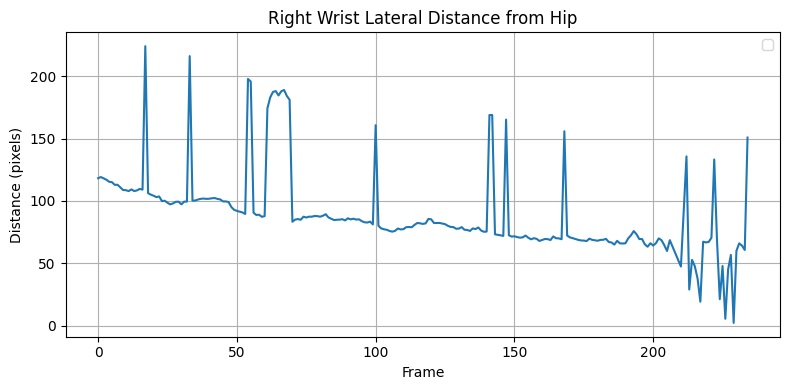

In [163]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the pose data
with open("./pose_keypoints/signal_clip_"+num+"_pose_id1.json", "r") as f:
    data = json.load(f)
    
# COCO indices
right_wrist_idx = 4
right_hip_idx = 12
left_hip_idx = 11

# Compute lateral (orthogonal to sagittal plane) distance
lateral_distances = []

for frame_data in data:
    keypoints = frame_data["keypoints"]
    frame_number = frame_data["frame"]

    # if len(keypoints) > max(right_wrist_idx, right_hip_idx):
    #     lateral_distance = np.linalg.norm(keypoints[right_wrist_idx][0])
    if len(keypoints) > max(right_wrist_idx, right_hip_idx, left_hip_idx):
        rw = np.array(keypoints[right_wrist_idx])
        rh = np.array(keypoints[right_hip_idx])
        lh = np.array(keypoints[left_hip_idx])

        # Hip-to-hip vector defines the lateral (left-right) axis
        hip_vec = rh - lh
        hip_vec_unit = hip_vec / (np.linalg.norm(hip_vec) + 1e-6)

        # Right wrist vector relative to right hip
        rw_vec = rw - rh

        # Orthogonal component (how far out laterally is the wrist from hip-hip line)
        projection = np.dot(rw_vec, hip_vec_unit) * hip_vec_unit
        orthogonal = rw_vec - projection
        lateral_distance = np.linalg.norm(orthogonal)
    else:
        lateral_distance = None

    lateral_distances.append({
        "frame": frame_number,
        "lateral_distance_rw_from_hipline": lateral_distance
    })

# Prepare for plotting
frames = [d["frame"] for d in lateral_distances if d["lateral_distance_rw_from_hipline"] is not None]
lateral_vals = [d["lateral_distance_rw_from_hipline"] for d in lateral_distances if d["lateral_distance_rw_from_hipline"] is not None]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(frames, lateral_vals)
plt.xlabel("Frame")
plt.ylabel("Distance (pixels)")
plt.title("Right Wrist Lateral Distance from Hip")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Savitzky-Golay Filter

/var/folders/49/1t01yqtj2zq_8lz44f1dk2n00000gn/T/ipykernel_25089/1620159134.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


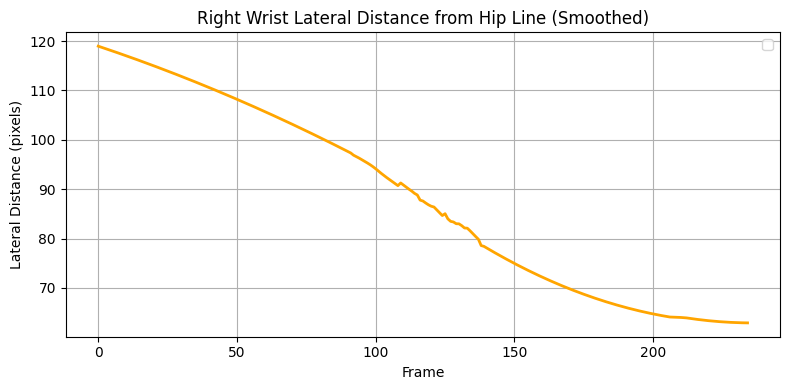

In [170]:
from scipy.signal import savgol_filter
import pandas as pd

# Create DataFrame from lateral distances
df_lat = pd.DataFrame(lateral_distances)
df_lat = df_lat.dropna()

# Apply Savitzky-Golay filter
df_lat["smoothed"] = savgol_filter(df_lat["lateral_distance_rw_from_hipline"], window_length=184, polyorder=2, mode='interp')

# Plot original vs smoothed
plt.figure(figsize=(8, 4))
plt.plot(df_lat["frame"], df_lat["smoothed"], linewidth=2, color="orange")
plt.xlabel("Frame")
plt.ylabel("Lateral Distance (pixels)")
plt.title("Right Wrist Lateral Distance from Hip Line (Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [171]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# Load video
video_path = "clips_cropped/signal_clip_"+num+"_pose_id1_overlay.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
W, H = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Setup matplotlib plot
smoothed = df_lat["smoothed"].values
fig, ax = plt.subplots(figsize=(8, 3.18))
ax.plot(frames, smoothed, color='orange')
line, = ax.plot([0, 0], [min(smoothed), max(smoothed)], 'r-', lw=2)
ax.set_title("Right Wrist Lateral Distance")
ax.set_xlabel("Frame")
ax.set_ylabel("Distance")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.draw()

# Writer
out_path = "clips_cropped/signal_clip_"+num+"_combined_overlay.mp4"
plot_height = 400
writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H + plot_height))

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret or frame_id >= len(smoothed):
        break

    # Update line
    line.set_xdata([frame_id, frame_id])
    fig.canvas.draw()
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_img = cv2.resize(plot_img, (W, plot_height))

    # Combine
    combined = np.vstack([frame, plot_img])
    writer.write(combined)

    frame_id += 1

cap.release()
writer.release()
plt.close()


/var/folders/49/1t01yqtj2zq_8lz44f1dk2n00000gn/T/ipykernel_25089/4083763701.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/49/1t01yqtj2zq_8lz44f1dk2n00000gn/T/ipykernel_25089/4083763701.py:40: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
